# 1 Create a Relational Model in SQLite

In [51]:
from peewee import *
from flask import flash 
from datetime import date, timedelta, datetime
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import json
import yaml
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects

# persist information
db = SqliteDatabase('assets.db')

class BaseModel(Model):
    class Meta:
        database = db

class Run(BaseModel): # This model uses the "assets.db" database.
    timestamp = DateTimeField(unique=True)
    symbol = CharField()
    id = AutoField()

class Price(BaseModel): # This model uses the "assets.db" database.
    datetime = DateTimeField(unique=True)
    volume_24 = FloatField()
    price = FloatField()
    runid = ForeignKeyField(Run, backref='prices')
         
# By default, Peewee includes an IF NOT EXISTS clause when creating tables. 
def create_tables():
    with db:
        db.create_tables([Price])
        db.create_tables([Run])

def drop_tables():
    with db:
        db.drop_tables([Price])
        db.drop_tables([Run])
        
create_tables()

#drop_tables()    

# 2 Query the API and Return Price Data as Stream

In [ ]:
symbol='BTCUSD'
query_interval = 5 # in seconds
query_number = 200 # the number of queries after which the API stops

# load the API key from our local file
with open(r'C:/Users/Flo/relataly-public-python-tutorials/coinmarketcap.yml') as file:
    apikey = yaml.load(file, Loader=yaml.FullLoader)['key']

# Define some essential API parameters
# Coinmarketcap API for latest market ticker quotes and averages for cryptocurrencies and exchanges.
# https://coinmarketcap.com/api/documentation/v1/#operation/getV1CryptocurrencyListingsLatest
url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
parameters = {
  'start':'1',
  'limit':'2',
  'convert':'USD'
}
headers = {
  'Accepts': 'application/json',
  'X-CMC_PRO_API_KEY': apikey,
}

session = Session()
session.headers.update(headers)

# create a new run and save it to our local SQLite DB
run_timestamp = datetime.now()
run = Run(symbol=symbol, timestamp = run_timestamp)
run.save()
current_run_id = run.id 
print(f'run_id: {current_run_id} - timestamp: {run_timestamp} - interval: {query_interval} - number of queries: {query_number}')

# query the coinmarketcap API every x seconds
for s in range(0, query_number):
    try:
        response = session.get(url, params=parameters)
        data = json.loads(response.text)
        #print(data)
        
        # response - quote
        data_quote = data['data'][0]['quote']['USD']
        price = np.round(data_quote['price'], 1) # the price
        volume_24 = np.round(data_quote['volume_24h'], 1) # the volume in the last 24 hours
        
        # response - status
        data_status = data['status']
        api_timestamp = data_status['timestamp'] # the timestamp of the pricepoint
        api_credits = data_status['credit_count'] # the number of credits spent on the last request
        
        # create a new pricepoint and save it to the SQLite db
        new_pricepoint = Price(datetime=api_timestamp, price=price, volume_24=volume_24, runid=current_run_id)
        id = new_pricepoint.save()

        # display what we have just saved
        print(f'request number: {s} - added {price} at {api_timestamp} - 24 hour volume: {volume_24} - credits used: {api_credits}')      

    except (ConnectionError, Timeout, TooManyRedirects) as e:
        print(e)
    time.sleep(query_interval)
print('finished')

run_id: 12 - timestamp: 2021-04-25 01:19:11.624670 - interval: 5 - number of queries: 200
request number: 0 - added 50385.1 at 2021-04-24T23:19:11.384Z - 24 hour volume: 49818844719.5 - credits used: 1


# 3 Query and Plot the Data

In [47]:
query = Run.select().where(Run.id==current_run_id)
run_overview = pd.DataFrame(list(query.dicts()))
run_overview

,id,timestamp,symbol
0,10,2021-04-24 23:57:24.758231,BTCUSD


    id                  datetime     volume_24    price  runid
0  131  2021-04-24T23:02:35.068Z  4.976121e+10  50310.6     11


(array([737241., 737425., 737607., 737791., 737972., 738156., 738337.,
        738521., 738702.]),
 <a list of 9 Text xticklabel objects>)

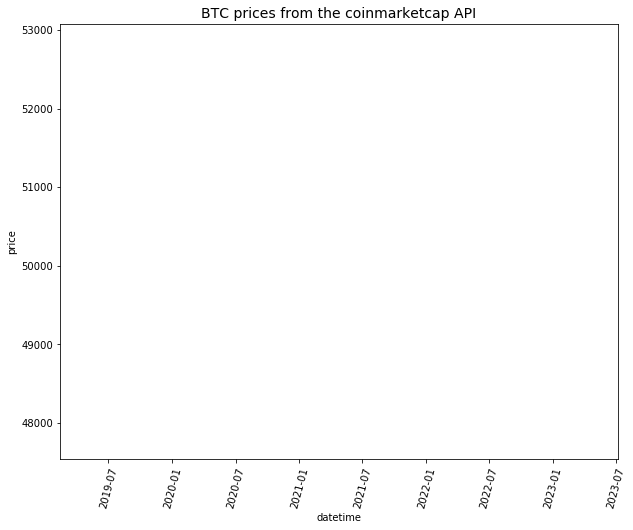

In [123]:
query = Price.select().where(Price.runid==current_run_id)
df_prices = pd.DataFrame(list(query.dicts()))
print(df_prices)

from pandas.plotting import register_matplotlib_converters
import matplotlib.dates as mdates
register_matplotlib_converters()
fig, ax = plt.subplots(figsize=(10, 8))
plt.title('BTC prices from the coinmarketcap API', fontsize=14)
datetimes = pd.to_datetime(df_prices['datetime'])

sns.lineplot(data=df_prices, x=datetimes, y="price")
#ax.set_xlim([df_prices['datetime'].min(),df_prices['datetime'].max()])
#ax.xaxis.set_major_locator(mdates.MinuteLocator())
plt.xticks(rotation=75)